## Explore the Zillow Data

* Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

* Answer those questions through a mix of statistical tests and visualizations.

__Acquire the data__

In [18]:
import numpy as np
import pandas as pd
import env
import wrangle_excs
import wrangle_zillow
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
zillow = wrangle_excs.wrangle_zillow()

<ipython-input-2-f990e3c00355>:1: DtypeWarning: Columns (62) have mixed types.Specify dtype option on import or set low_memory=False.
  zillow = wrangle_excs.wrangle_zillow()
/Users/johnathonsmith/opt/miniconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [3]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69523 entries, 0 to 77380
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   69523 non-null  float64
 1   bedroomcnt                    69523 non-null  float64
 2   buildingqualitytypeid         69523 non-null  float64
 3   calculatedfinishedsquarefeet  69523 non-null  float64
 4   fips                          69523 non-null  float64
 5   latitude                      69523 non-null  float64
 6   longitude                     69523 non-null  float64
 7   lotsizesquarefeet             69523 non-null  float64
 8   rawcensustractandblock        69523 non-null  float64
 9   regionidcity                  69523 non-null  float64
 10  regionidcounty                69523 non-null  float64
 11  regionidzip                   69523 non-null  float64
 12  roomcnt                       69523 non-null  float64
 13  u

__Prepare Zillow Data__

In [8]:
#The data is mostly prepared, just need to remove some outliers
#Now remove things that don't make sense and/or are impossible/illegal.
#If something doesn't sound like the average 'single unit' property, drop it.
zillow = zillow[(zillow.bedroomcnt > 0) & (zillow.bathroomcnt> 0)]
zillow = zillow[zillow.bedroomcnt <= 5]
zillow = zillow[zillow.bathroomcnt <= 3]
zillow = zillow[zillow['calculatedfinishedsquarefeet'] <= 5000]
zillow = zillow[zillow['calculatedfinishedsquarefeet'] >= (120 * zillow.bedroomcnt)]
zillow = zillow[zillow.taxamount <= 20_000]

In [9]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63358 entries, 1 to 77380
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   63358 non-null  float64
 1   bedroomcnt                    63358 non-null  float64
 2   buildingqualitytypeid         63358 non-null  float64
 3   calculatedfinishedsquarefeet  63358 non-null  float64
 4   fips                          63358 non-null  float64
 5   latitude                      63358 non-null  float64
 6   longitude                     63358 non-null  float64
 7   lotsizesquarefeet             63358 non-null  float64
 8   rawcensustractandblock        63358 non-null  float64
 9   regionidcity                  63358 non-null  float64
 10  regionidcounty                63358 non-null  float64
 11  regionidzip                   63358 non-null  float64
 12  roomcnt                       63358 non-null  float64
 13  u

__Check Variable Distributions__

In [10]:
#Plot the individual distributions
def get_dists(df):
    for col in df.columns:
        sns.histplot(x = col, data = df)
        plt.title(col)
        plt.show()

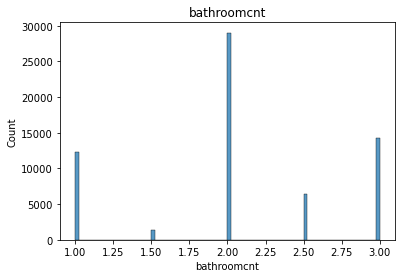

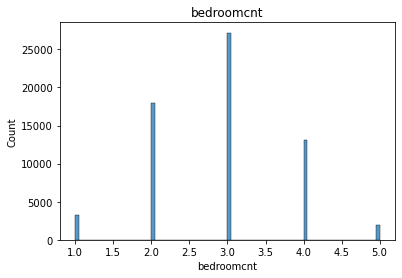

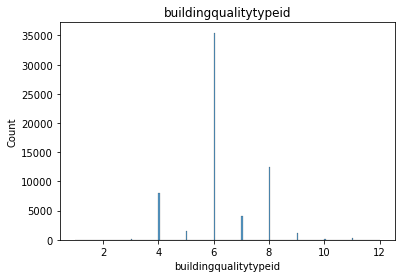

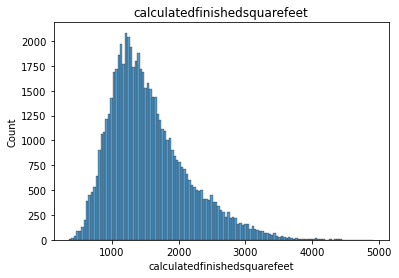

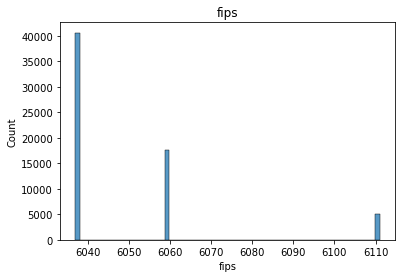

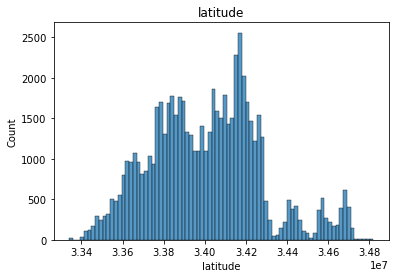

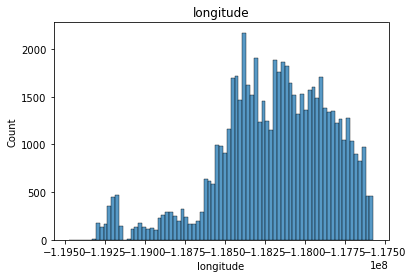

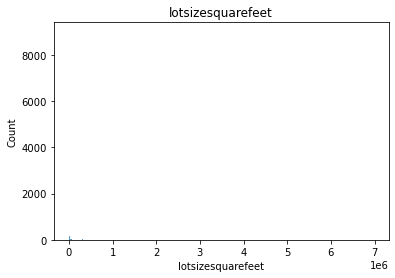

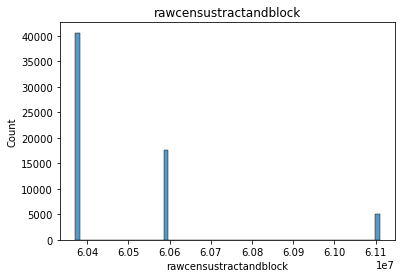

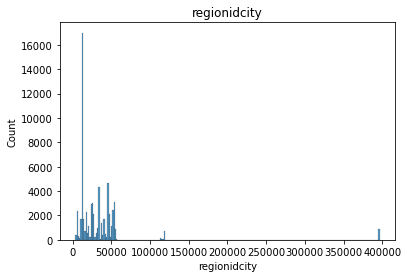

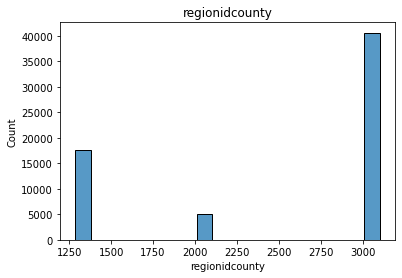

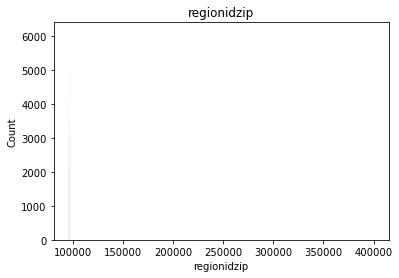

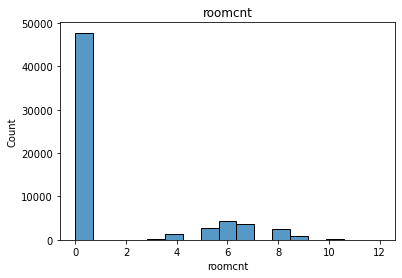

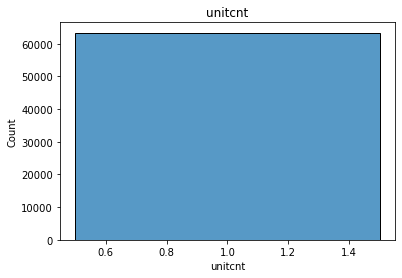

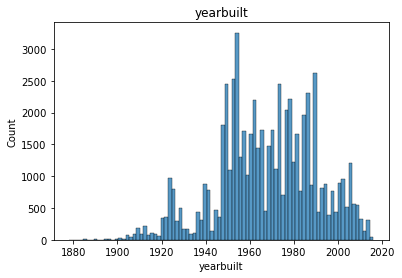

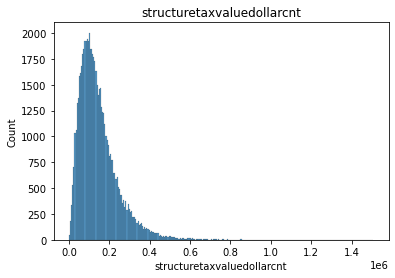

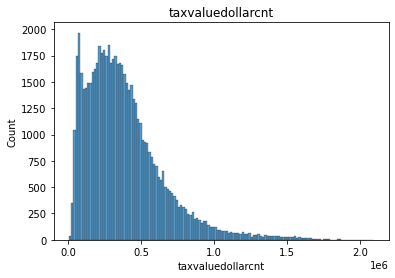

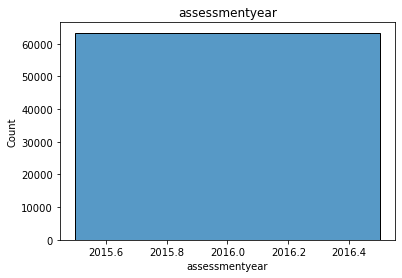

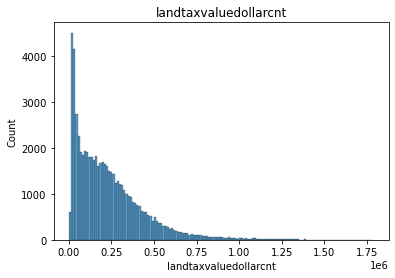

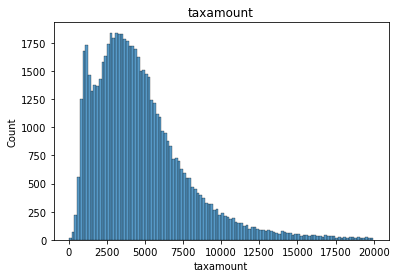

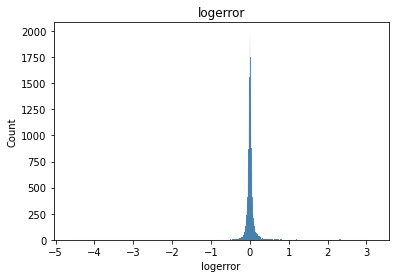

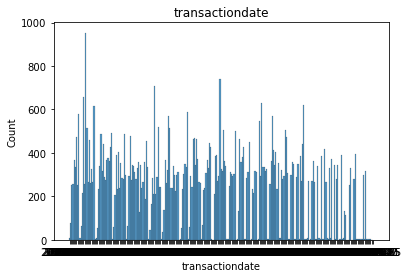

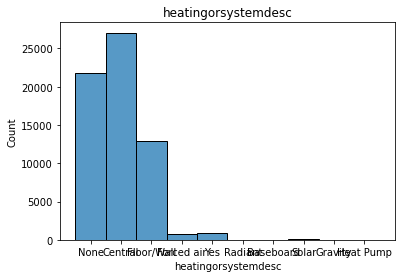

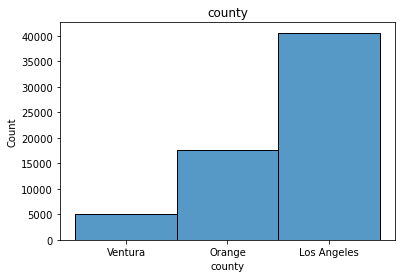

In [11]:
get_dists(zillow)

In [12]:
#Now split the data into train, validate, test
train, validate, test = wrangle_excs.train_validate_test_split(zillow)

__Explore the Data__

__Question 1: Is log error significantly different for properties from county to county?__

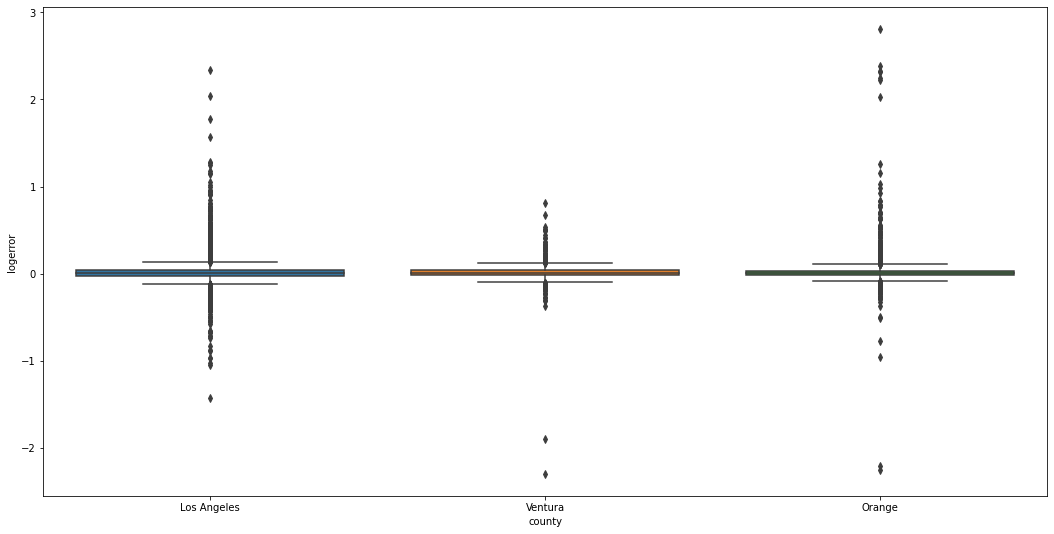

In [39]:
#Visualize
plt.figure(figsize=(18,9))
sns.boxplot(x = 'county', y = 'logerror', data = train.sample(9000))
plt.show()

Its hard to make any judgement calls on the figure alone, so I'll use statistical testing to verify.

__LA County Vs. Orange County__

$H_0$: Average logerror for properties in Los Angelas County == Average logerror for properties in Orange County.

$H_a$: Average logerror for properties in Los Angels County != Average logerror for properties in Orange County.

In [16]:
alpha = 0.05

In [26]:
#Create sets for each county
la_county = train[train.county == 'Los Angeles'].copy()
orange_county = train[train.county == 'Orange'].copy()
ventura_county = train[train.county == 'Ventura'].copy()

In [27]:
#Assume variances are not equal.
t, p = stats.ttest_ind(la_county.logerror, orange_county.logerror, equal_var = False)
t, p

(-2.1727232959066822, 0.029814276626947973)

__Result__

p-value is less than 0.05, so we reject the null hypothesis. Average logerror for properties in Los Angeles County is significantly different than average logerror for properties in Orange County.

__LA County Vs. Ventura County__

$H_0$: Average logerror for properties in Los Angelas County == Average logerror for properties in Ventura County.

$H_a$: Average logerror for properties in Los Angels County != Average logerror for properties in Ventura County.

In [28]:
alpha = 0.05

In [29]:
#Assume variances are not equal
t, p = stats.ttest_ind(la_county.logerror, ventura_county.logerror, equal_var = False)
t, p

(-0.29868364589589075, 0.765197980651783)

__Result__

p-value is greater than 0.05, so we fail to reject the null hypothesis. Average logerror for properties in Los Angeles County is not significantly different than the average logerror for properties in Ventura County.

__Orange County Vs. Ventura County__

$H_0$: Average logerror for properties in Orange County == Average logerror for properties in Ventura County.

$H_a$: Average logerror for properties in Orange County != Average logerror for properties in Ventura County.

In [30]:
alpha = 0.05

In [31]:
#Assume variances are not equal
t, p = stats.ttest_ind(orange_county.logerror, ventura_county.logerror, equal_var = False)
t, p

(1.0001750389987096, 0.3172715627522714)

__Result__

p-value is greater than 0.05, so we fail to reject the null hypothesis. Average logerror for properties in Orange County is not significantly different than the average logerror for properties in Ventura County.

__Key Takeaways:__
    
* Average logerror for properties in Los Angeles County is significantly different than the average logerror for properties in Orange County, but there is no significant difference between the others.
* For this reason, I'm not sure that county would be a good feature in and of itself, but maybe further exploration will be able to explain these findings.